In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

imputedDataset = pd.read_stata("/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")
imputedDataset.head()
noRecentUSInmigration = imputedDataset.loc[~imputedDataset.timeInUS.isin([1,2,3])]
earlyCrossSectionOfNonImmigrants = noRecentUSInmigration.loc[noRecentUSInmigration.year==2001]
# here we just need to throw out the very young people for comparisons
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.loc[earlyCrossSectionOfNonImmigrants.age > 18 + 2]

earlyCrossSectionOfNonImmigrants['strokeDeath'] = np.where(((earlyCrossSectionOfNonImmigrants.diedBy2011.values == 1) & (earlyCrossSectionOfNonImmigrants.ucod.values==2)), 1, 0)
earlyCrossSectionOfNonImmigrants['miDeath'] = np.where(((earlyCrossSectionOfNonImmigrants.diedBy2011.values == 1) & (earlyCrossSectionOfNonImmigrants.ucod.values==1)), 1, 0)

earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.sample(n=100000, weights=earlyCrossSectionOfNonImmigrants.WTINT2YR, replace=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
earlyCrossSectionOfNonImmigrants.miDeath.value_counts()

0    96082
1     3918
Name: miDeath, dtype: int64

In [9]:
import os
os.chdir("/Users/burke/Documents/research/bpCog/mcm")
from mcm.population import NHANESDirectSamplePopulation

pop = NHANESDirectSamplePopulation(n=10000, year=1999)

In [10]:
popSurvival = pd.DataFrame({"index" : pop._people.index, "baseAge" : [person._age[0] for person in pop._people]} )
popSurvival['ageDecile'] = pd.qcut(popSurvival.baseAge, 10)
for year in range(1,11):
    pop.advance(1)
    popSurvival['dead' + str(year)] = [person.is_dead() for person in pop._people]
    popSurvival['cvDeath' + str(year)] = [person.has_fatal_stroke() or person.has_fatal_mi() for person in pop._people]
    popSurvival['strokeDeath' + str(year)] = [person.has_fatal_stroke() for person in pop._people]
    popSurvival['miDeath' + str(year)] = [person.has_fatal_mi() for person in pop._people]
    popSurvival['nonCVDeath' + str(year)] = [person.is_dead() and (person.has_fatal_stroke() ==False) and (person.has_fatal_mi() == False) for person in pop._people]

In [11]:
earlyCrossSectionOfNonImmigrants.diedBy2011.value_counts(normalize=True)

0    0.881
1    0.119
Name: diedBy2011, dtype: float64

In [12]:
# on UCOD 1 = MI, 2=stroke, 3 = other cause of death
earlyCrossSectionOfNonImmigrants.ucod.value_counts(normalize=True, sort=False)

0    0.88180
1    0.03918
2    0.00741
3    0.07161
Name: ucod, dtype: float64

In [13]:
popSurvival.dead10.value_counts(normalize=True)

False    0.8591
True     0.1409
Name: dead10, dtype: float64

In [14]:
popSurvival.cvDeath10.value_counts(normalize=True)

False    0.9365
True     0.0635
Name: cvDeath10, dtype: float64

In [15]:
popSurvival.nonCVDeath10.value_counts(normalize=True)

False    0.9226
True     0.0774
Name: nonCVDeath10, dtype: float64

In [16]:
popSurvival.miDeath10.value_counts(normalize=True)

False    0.9638
True     0.0362
Name: miDeath10, dtype: float64

In [17]:
popSurvival.strokeDeath10.value_counts(normalize=True)

False    0.9727
True     0.0273
Name: strokeDeath10, dtype: float64

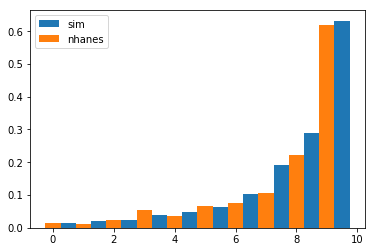

In [18]:
earlyCrossSectionOfNonImmigrants['ageDecile'] = pd.qcut(earlyCrossSectionOfNonImmigrants.age, 10)


mortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['diedBy2011','ageDecile']].groupby(earlyCrossSectionOfNonImmigrants.ageDecile).mean()
mortalityByDecileSim = popSurvival[['dead10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

simBar =plt.bar(mortalityByDecileSim.index.codes+0.5, mortalityByDecileSim.dead10, width=0.5, label="sim")
nhanesBar = plt.bar(mortalityByDecileNHANES.index.codes, mortalityByDecileNHANES.diedBy2011, width=0.5, label="nhanes")
plt.legend()


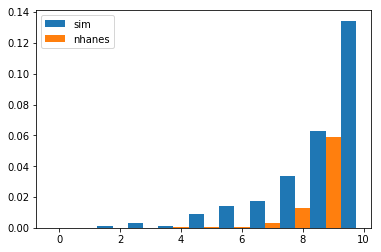

In [24]:

strokeMortalityByDecileNHANES = earlyCrossSectionOfNonImmigrants[['strokeDeath','ageDecile']].groupby(earlyCrossSectionOfNonImmigrants.ageDecile).mean()
mortalityByDecileSim = popSurvival[['strokeDeath10', 'ageDecile']].groupby(popSurvival.ageDecile).mean()

simBar =plt.bar(mortalityByDecileSim.index.codes+0.5, mortalityByDecileSim.strokeDeath10, width=0.5, label="sim")
nhanesBar = plt.bar(mortalityByDecileNHANES.index.codes, strokeMortalityByDecileNHANES.strokeDeath, width=0.5, label="nhanes")
plt.legend()

In [20]:
strokeMortalityByDecileNHANES

,strokeDeath
ageDecile,
"(20.999, 26.0]",0.000000
"(26.0, 31.0]",0.000000
"(31.0, 36.0]",0.000000
"(36.0, 40.0]",0.000000
"(40.0, 45.0]",0.000601
"(45.0, 49.0]",0.000737
"(49.0, 54.0]",0.000596
"(54.0, 61.0]",0.003061
"(61.0, 72.0]",0.013141


In [25]:
mortalityByDecileSim

,strokeDeath10
ageDecile,
"(18.999, 23.0]",0.000000
"(23.0, 29.0]",0.000847
"(29.0, 33.0]",0.003367
"(33.0, 37.0]",0.001079
"(37.0, 42.0]",0.008651
"(42.0, 46.0]",0.014052
"(46.0, 52.0]",0.017206
"(52.0, 60.0]",0.033605
"(60.0, 70.0]",0.062880


### So, we have slight under prediction of mortality in the simulation. Is that because of the code or the data?

To test — we will rerun the simulation on the direct NHANES data that we use in the calibration...

In [ ]:
from mcm.gender import NHANESGender
from mcm.person import Person
from mcm.outcome import Outcome
from mcm.race_ethnicity import NHANESRaceEthnicity
from mcm.smoking_status import SmokingStatus
from mcm.cohort_risk_model_repository import CohortRiskModelRepository
from mcm.outcome_model_repository import OutcomeModelRepository

In [ ]:
import os 

def calcMortalityRunningFullModel(x):
        temp =  Person(
            age=x.age,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSBP,
            dbp=x.meanDBP,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.tot_chol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
        
        for year in range(1,11):
            if not temp.is_dead():
                temp.advance_year(riskModel, cohortModel)
        return temp.is_dead()

earlyCrossSectionOfNonImmigrants['estMortalityFromModel'] = earlyCrossSectionOfNonImmigrants.apply(calcMortalityRunningFullModel, axis=1)

In [ ]:
earlyCrossSectionOfNonImmigrants['ageDecile'] = pd.qcut(earlyCrossSectionOfNonImmigrants.age, 10)
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['diedBy2011', 'estMortalityFromModel']].mean()
print(output)
plt.bar(output.index.codes+1, output.diedBy2011, width=0.5, label="actualDeath")
plt.bar(output.index.codes+1.5, output.estMortalityFromModel, width=0.5, label="model")

plt.legend()

### Ok...this looks quite good...on the same data, the under-prediction problem looks very modest

In [ ]:
earlyCrossSectionOfNonImmigrants.to_stata("/Users/burke/Documents/research/bpCog/nhanes/earlyCrossSectionOfNonImmigrants.dta")
earlyCrossSectionOfNonImmigrants.ageDecile.value_counts().sort_index()

In [ ]:
earlyCrossSectionOfNonImmigrants[['diedBy2011', 'estMortalityFromCox', 'estMortalityFromModel']].mean()

In [ ]:
# well...this is not easy to explain.
# for the most part the code-bsaed calculation looks similar, gut it under predicts mortaltiy substantially in the highest age decile
# this is a bit strange...but, not impossible. if you look at the within population validation, it seems that we under-predicted in the oldest cohort for our basee model as well
# i wonder if having a longer follow-up (by constraining to the early oohort might cause that problem...that should be straight-forward to check)

# the code based model is over-estmiaging mortalty thorughout.
# this is going to be harder to figure otu...
# possibilities: 1. the times aren't right...and the cohort model is getting exposed to more time than the comparators
# the time aggregation isn't right...the one year probabilities are summing to something greater than the whole

In [ ]:
earlyCrossSectionOfNonImmigrants.ucod.value_counts()

In [ ]:
# next steps — 1. see if we under-preditx mortality badly in the NHANES popualtion if we look at only the people that are enrolled early (and thus have long follow-up)